In [1]:
!rm -rf * .* 2>/dev/null
!rm -rf ~/.kaggle && mkdir ~/.kaggle
!echo eyJ1c2VybmFtZSI6InB2dHNlYzB4MSIsImtleSI6IjZlOTYxZmMxYjdhYzU2OTlmNzcwYmFjMjI1NTk4MWIwIn0= | base64 -d > ~/.kaggle/kaggle.json
!git clone https://github.com/Reshmavineesh/SunLit-Segmentation .
!git checkout dev
!./download_dataset.sh
from IPython.display import clear_output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'; clear_output()
print("Dataset ready")

Dataset ready


In [2]:
import utils
import tensorflow as tf

image_path = 'dataset/dataset_tomato_128/color_images/'
mask_path = 'dataset/dataset_tomato_128/masks/'
n_val = 200

train_images, train_masks, test_images, test_masks = utils.load_dataset(image_path, mask_path, n_val)
print(f"Train Images:\t{train_images.shape}")
print(f"Train Masks:\t{train_masks.shape}")
print(f"Test Images:\t{test_images.shape}")
print(f"Test Masks:\t{test_masks.shape}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Train Images:	(4648, 128, 128, 3)
Train Masks:	(4648, 128, 128)
Test Images:	(4648, 128, 128, 3)
Test Masks:	(4648, 128, 128)


In [3]:
from keras_models.models import SegNet
from tensorflow.keras.callbacks import EarlyStopping


EPOCHS = 200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss=utils.dice_loss
metrics = ['accuracy']
input_shape = train_images.shape[1:]

train_attr = {
    "lr": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "optimizer": optimizer.get_config()['name'],
    "loss_fn": loss.get_config()['name']
}

model = SegNet(input_shape)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train_images,
                    train_masks,
                    validation_split = 0.25,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks=[early_stopper])

Epoch 1/200
218/218 [==============================] - 87s 279ms/step - loss: 0.5872 - accuracy: 0.7050 - val_loss: 0.6541 - val_accuracy: 0.7463
Epoch 2/200
218/218 [==============================] - 57s 264ms/step - loss: 0.5547 - accuracy: 0.7454 - val_loss: 0.5033 - val_accuracy: 0.6776
Epoch 3/200
218/218 [==============================] - 58s 267ms/step - loss: 0.5253 - accuracy: 0.7703 - val_loss: 0.5095 - val_accuracy: 0.7858
Epoch 4/200
218/218 [==============================] - 59s 269ms/step - loss: 0.5024 - accuracy: 0.7841 - val_loss: 0.4948 - val_accuracy: 0.5824
Epoch 5/200
218/218 [==============================] - 58s 266ms/step - loss: 0.4959 - accuracy: 0.7834 - val_loss: 0.4439 - val_accuracy: 0.7885
Epoch 6/200
218/218 [==============================] - 57s 264ms/step - loss: 0.4810 - accuracy: 0.7929 - val_loss: 0.4528 - val_accuracy: 0.8065
Epoch 7/200
218/218 [==============================] - 57s 264ms/step - loss: 0.4678 - accuracy: 0.7967 - val_loss: 0.4138 -

1/1 [==============================] - 0s 34ms/step


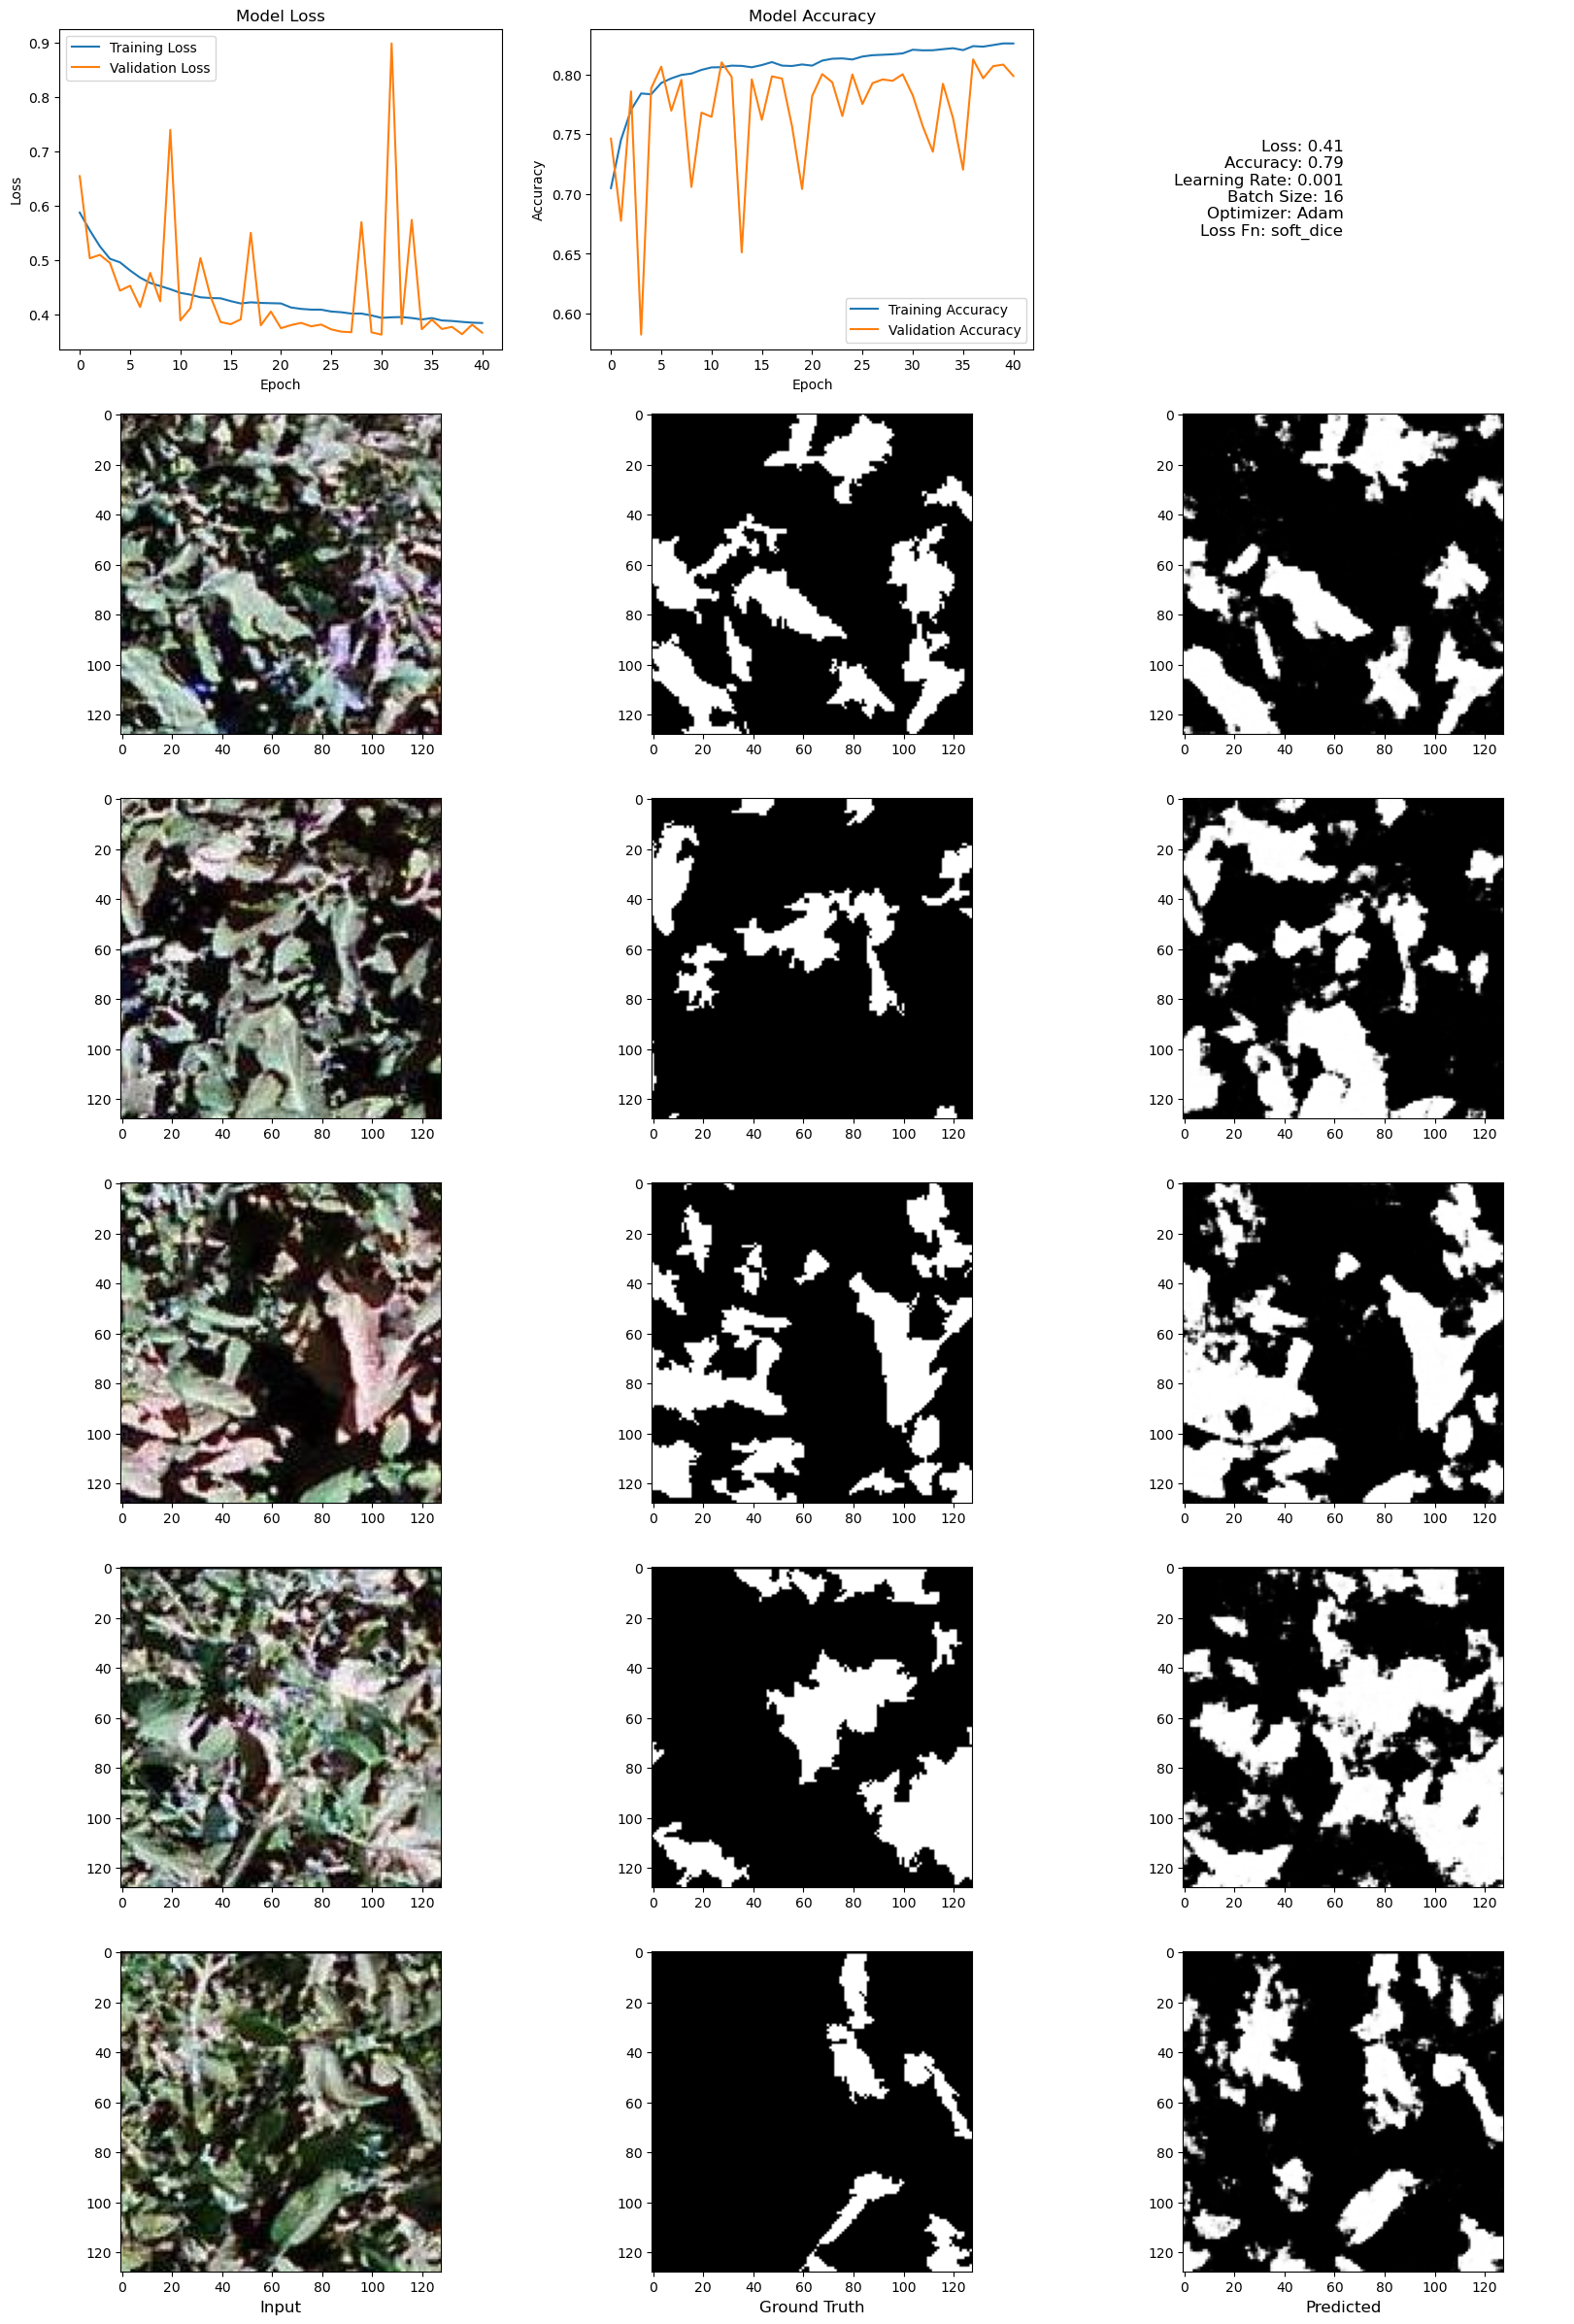

In [4]:
utils.analyzer(history, model, image_path, mask_path, test_images, test_masks, train_attr)